In [23]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

# Load data

In [24]:
from src.load_data import get_epidemic_data, get_vaccine_data

### Epidemic data

In [25]:
df_epidemic = get_epidemic_data('Italy')
df_epidemic.head()

,Total cases,Active infected,Total deaths,Total recovered,Daily cases (avg 7 days),Daily deaths (avg 7 days)
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0


### Vaccine data

In [26]:
df_vaccine = get_vaccine_data('Italy')
df_vaccine.head()

,% vaccinated with 1 dose,% vaccinated with 2 doses
date,,
2020-12-29,0.02,0.0
2020-12-30,0.02,0.0
2020-12-31,0.07,0.0
2021-01-01,0.08,0.0
2021-01-02,0.15,0.0


In [27]:
media_ultimo_mese = int(np.mean(np.diff(np.sum(df_vaccine[-30:],axis=1))*60*10**6)/100)

print('vaccinazioni medie nell\'ultimo mese',media_ultimo_mese)

vaccinazioni medie nell'ultimo mese 216413


### Merging the two dataframes

In [28]:
df_merged = df_vaccine.join(df_epidemic,on=df_vaccine.index)

# the 3rd wave in Italy started approximately the 23th of February 2021, 
# with the increasing in the number of hospitalized people
df_merged = df_merged[df_merged.index >= '2021-02-24']

df_merged.head()

,% vaccinated with 1 dose,% vaccinated with 2 doses,Total cases,Active infected,Total deaths,Total recovered,Daily cases (avg 7 days),Daily deaths (avg 7 days)
date,,,,,,,,
2021-02-24,4.19,2.26,2848564.0,389433.0,96666.0,2362465.0,13843.9,303.7
2021-02-25,4.39,2.28,2868435.0,396143.0,96974.0,2375318.0,14717.6,298.1
2021-02-26,4.59,2.31,2888923.0,404664.0,97227.0,2387032.0,15434.4,284.6
2021-02-27,4.78,2.32,2907825.0,411966.0,97507.0,2398352.0,16004.1,288.7
2021-02-28,4.89,2.34,2925265.0,422367.0,97699.0,2405199.0,16574.1,283.0


# Fit of the epidemiological model

In [29]:
from src.epi_model import SIR2
from src.optimizer import fit_model

In [30]:
inhabitants = 60*10**6

# true data vaccine
ydata_vacc = np.array(df_merged['% vaccinated with 2 doses'])*inhabitants/100
vacc_eff = 1
vacc_speed = 0.1

tmax = len(ydata_vacc)

# true data epidemic
ydata_cases = np.array(df_merged['Total cases']) + ydata_vacc
ydata_inf = np.array(df_merged['Active infected'])
ydata_rec = (np.array(df_merged['Total recovered'])+np.array(df_merged['Total deaths']))

# optimization of the parameters of the SIR 2.0 model
minpar = fit_model(y_data = [ydata_cases,ydata_inf,ydata_rec],
                   inhabitants=inhabitants,
                   vacc_eff = vacc_eff,
                   vacc_speed = vacc_speed,
                   V0 = ydata_vacc[0],
                   which_error = 'perc')

Optimization terminated successfully.
         Current function value: 0.792263
         Iterations: 235
         Function evaluations: 420
Error on susceptible 0.3 %
Error on infected 1.5 %
Error on removed 0.6 %
The average error of the model is 0.8 %


In [31]:
beta = round(minpar[0],3)
gamma = round(minpar[1],3)
tau = round(minpar[2],1)

if tau >= 1000:
    tau=np.inf

print('Parametri ottimizzati: beta',beta,'gamma',gamma,'tau',tau)

Parametri ottimizzati: beta 0.06 gamma 0.031 tau 64.7


In [32]:
model_check = SIR2(inhabitants,minpar[0],minpar[1],minpar[2],
              vacc_eff=vacc_eff,
              vacc_speed=vacc_speed,
              t0=0,  
              I0=ydata_inf[0],
              R0=ydata_rec[0],
              V0=ydata_vacc[0])

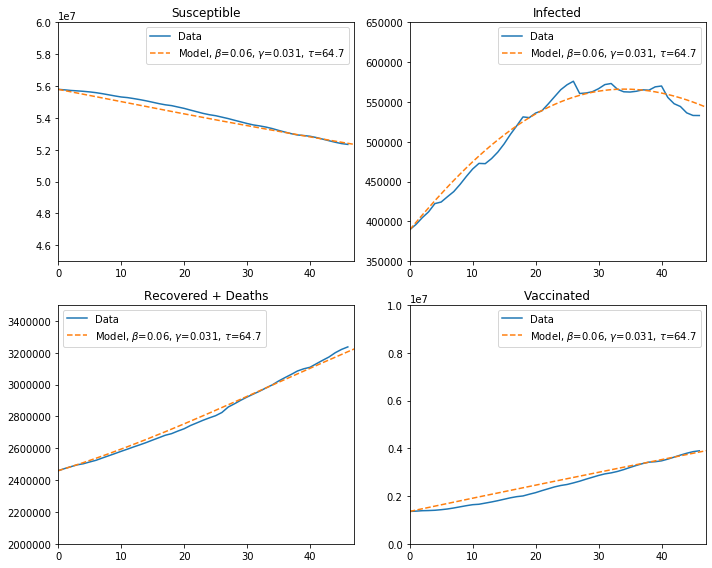

In [33]:
# check del modello, con curve di suscettibili, infetti e rimossi

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(inhabitants-ydata_cases,label='Data')
plt.plot(model_check[1],
         linestyle='--',label='Model, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.xlim(0,tmax)
plt.ylim(45*10**6,60*10**6)
plt.title('Susceptible')
plt.legend()
plt.subplot(2,2,2)
plt.plot(ydata_inf,label='Data')
plt.plot(model_check[2],
         linestyle='--',label='Model, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.xlim(0,tmax)
plt.ylim(3.5*10**5,6.5*10**5)
plt.title('Infected')
plt.legend()
plt.subplot(2,2,3)
plt.plot(ydata_rec,label='Data')
plt.plot(model_check[3],
         linestyle='--',label='Model, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.xlim(0,tmax)
plt.title('Recovered + Deaths')
plt.ylim(2*10**6,3.5*10**6)
plt.legend()
plt.subplot(2,2,4)
plt.plot(ydata_vacc,label='Data')
plt.plot(model_check[4],
         linestyle='--',label='Model, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.xlim(0,tmax)
plt.title('Vaccinated')
plt.ylim(0,10**7)
plt.legend()
plt.tight_layout()
plt.savefig('results/check_model_italy3rd.png',dpi=300)
plt.show()

### previsioni del modello epidemiologico

In [39]:
# model that accounts for lockdown (tau) and vaccination (vacc_speed)

pred_lockdown_vaccine=SIR2(inhabitants,minpar[0],minpar[1],minpar[2],
                           vacc_eff = vacc_eff,
                           vacc_speed = vacc_speed,
                           t0=0,
                           I0=ydata_inf[0],
                           R0=ydata_rec[0],
                           V0=ydata_vacc[0]) 

pred_lockdown_vaccine_best=SIR2(inhabitants,minpar[0],minpar[1],minpar[2],
                           vacc_eff = vacc_eff,
                           vacc_speed = vacc_speed,
                           t0=0,
                           I0=ydata_inf[0],
                           R0=ydata_rec[0],
                           V0=ydata_vacc[0],
                           vacc_custom = [len(ydata_cases),0.25]) 

pred_lockdown_vaccine_zero=SIR2(inhabitants,minpar[0],minpar[1],minpar[2],
                           vacc_eff = 0,
                           vacc_speed = vacc_speed,
                           t0=0,
                           I0=ydata_inf[0],
                           R0=ydata_rec[0],
                           V0=ydata_vacc[0],
                           vacc_custom = [len(ydata_cases),0]) 

# Risultati

In [40]:
# vaccinati con 1 dose e con 2 dosi
vaccinated_1dose = np.array(df_merged['% vaccinated with 1 dose'])
vaccinated_2dose = np.array(df_merged['% vaccinated with 2 doses'])

# incidenza settimanale ogni 100.000 abitanti
weekly_incidence = 7/(inhabitants/10**5)*np.array(df_merged['Daily cases (avg 7 days)'])

# decessi giornalieri per milione di abitanti
daily_deaths = 1/(inhabitants/10**6)*np.array(df_merged['Daily deaths (avg 7 days)'])

# dati sugli infetti attivi
ydata_inf_complete = np.array(df_merged['Active infected'])

xticks_21 = ['24 Feb','10 Mar','24 Mar','7 Apr','21 Apr','5 Mag','19 Mag',
             '2 Giu','16 Giu','30 Giu','14 Lug','28 Lug','11 Ago','25 Ago']

### grafico in stile Israele

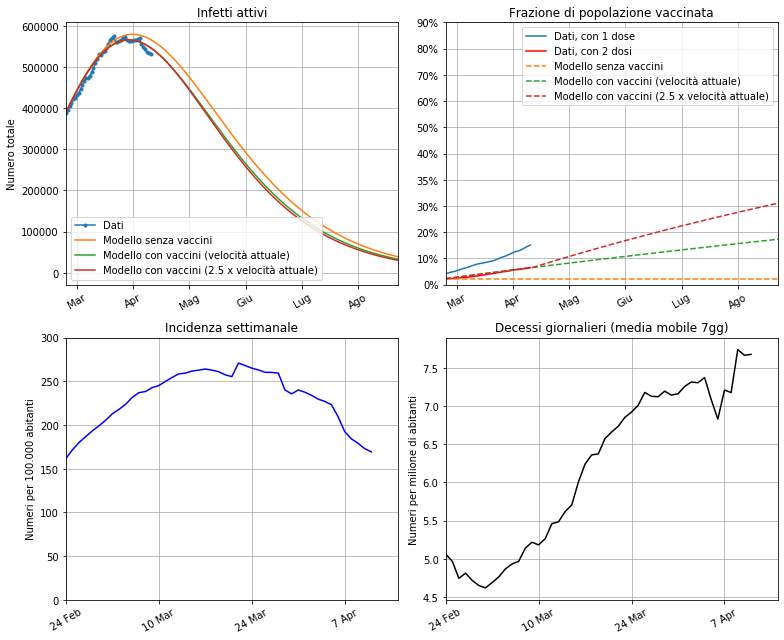

In [42]:
xgrid = np.arange(0,len(pred_lockdown_vaccine[2]))

plt.figure(figsize=(11,9))
plt.subplot(2,2,1)
plt.plot(ydata_inf_complete,marker='.',label='Dati')
#plt.plot(ydata_inf[0:27],marker='.',label='Data used for fitting',color='cyan')
plt.plot(pred_lockdown_vaccine_zero[2],label='Modello senza vaccini')
plt.plot(pred_lockdown_vaccine[2],label='Modello con vaccini (velocità attuale)')
plt.plot(pred_lockdown_vaccine_best[2],label='Modello con vaccini (2.5 x velocità attuale)')
#plt.fill_between(xgrid,pred_lockdown_vaccine[2],pred_lockdown_vaccine_best[2],color='black',alpha=0.3)
plt.title('Infetti attivi')
plt.ylabel('Numero totale')
plt.xticks(np.arange(6,250,30.5),['Mar','Apr','Mag','Giu','Lug','Ago','Set','Ott'],rotation=30)
plt.xlim(0,180)
plt.grid()
plt.legend()
plt.subplot(2,2,2)
plt.title('Frazione di popolazione vaccinata')
plt.plot(vaccinated_1dose,label='Dati, con 1 dose')
plt.plot(vaccinated_2dose,label='Dati, con 2 dosi',color='red')
plt.plot(pred_lockdown_vaccine_zero[4]/inhabitants*100,label='Modello senza vaccini',linestyle='--')
plt.plot(pred_lockdown_vaccine[4]/inhabitants*100,label='Modello con vaccini (velocità attuale)',linestyle='--')
plt.plot(pred_lockdown_vaccine_best[4]/inhabitants*100,label='Modello con vaccini (2.5 x velocità attuale)',linestyle='--')
plt.xticks(np.arange(6,250,30.5),['Mar','Apr','Mag','Giu','Lug','Ago','Set','Ott'],rotation=30)
plt.yticks(np.arange(0,102,10),['0%','10%','20%','30%','35%','40%','50%','60%','70%','80%','90%','100%'])
plt.ylim(0,100)
plt.xlim(0,180)
plt.grid()
plt.legend()
plt.subplot(2,2,3)
plt.plot(weekly_incidence,color='blue')
plt.title('Incidenza settimanale')
plt.ylabel('Numeri per 100.000 abitanti')
plt.xticks(np.arange(0,100,14),xticks_21,rotation=30)
plt.ylim(0,300)
plt.xlim(0,len(vaccinated_1dose)+3)
plt.grid()
plt.subplot(2,2,4)
plt.plot(daily_deaths,color='black')
plt.title('Decessi giornalieri (media mobile 7gg)')
plt.ylabel('Numeri per milione di abitanti')
plt.xticks(np.arange(0,100,14),xticks_21,rotation=30)
plt.xlim(0,len(vaccinated_1dose)+3)
plt.grid()
plt.tight_layout()
plt.savefig('results/predicted-italy_3rdwave.png',dpi=300)
plt.show()

### grafico best fit

In [43]:
t12 = 0.69*tau

print('Tempo di dimezzamento di Rt = ',t12,'giorni')

xlab = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']

Tempo di dimezzamento di Rt =  44.643 giorni


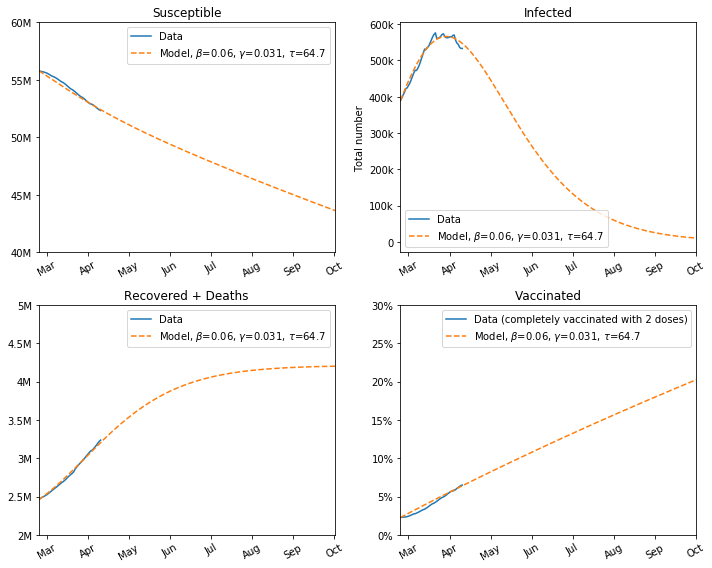

In [45]:
# check del modello, con curve di suscettibili, infetti e rimossi

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(inhabitants-ydata_cases,label='Data')
plt.plot(pred_lockdown_vaccine[1],linestyle='--',
         label='Model, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.xticks(np.arange(6,250,30.5),xlab,rotation=30)
plt.xlim(0,220)
plt.yticks(10**7*np.arange(0,6.1,0.5),['0','5M','10M','15M','20M','25M','30M','35M','40M','45M','50M','55M','60M'])
plt.ylim(40*10**6,60*10**6)
plt.title('Susceptible')
plt.legend()
plt.subplot(2,2,2)
plt.plot(ydata_inf_complete,label='Data')
plt.plot(pred_lockdown_vaccine[2],linestyle='--',
         label='Model, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.title('Infected')
plt.yticks(10**5*np.arange(0,6.1,1),['0','100k','200k','300k','400k','500k','600k'])
plt.ylabel('Total number')
plt.xticks(np.arange(6,250,30.5),xlab,rotation=30)
plt.xlim(0,220)
plt.legend(loc=3)
plt.subplot(2,2,3)
plt.plot(ydata_rec,label='Data')
plt.plot(pred_lockdown_vaccine[3],linestyle='--',
         label='Model, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.xticks(np.arange(6,250,30.5),xlab,rotation=30)
plt.xlim(0,220)
plt.title('Recovered + Deaths')
plt.yticks(10**6*np.arange(0,6.1,0.5),['0','0.5M','1M','1.5M','2M','2.5M','3M','3.5M','4M','4.5M','5M','5.5M','6M'])
plt.ylim(2*10**6,5*10**6)
plt.legend()
plt.subplot(2,2,4)
plt.title('Vaccinated')
plt.plot(vaccinated_2dose,label='Data (completely vaccinated with 2 doses)')
plt.plot(pred_lockdown_vaccine[4]/inhabitants*100,linestyle='--',
         label='Model, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
#plt.plot(pred_lockdown_vaccine_best[4]/inhabitants*100,label='Modello con vaccini (2.5 x velocità attuale)')
plt.xticks(np.arange(6,250,30.5),xlab,rotation=30)
plt.yticks(np.arange(0,31,5),['0%','5%','10%','15%','20%','25%','30%'])
plt.ylim(0,30)
plt.xlim(0,220)
plt.legend()
plt.tight_layout()
plt.savefig('results/modello_italia_ondata3_vaccini.png',dpi=300)
plt.show()

### grafico con bande

In [53]:
tmax = 220
xgrid = np.arange(0,len(pred_lockdown_vaccine[1]))

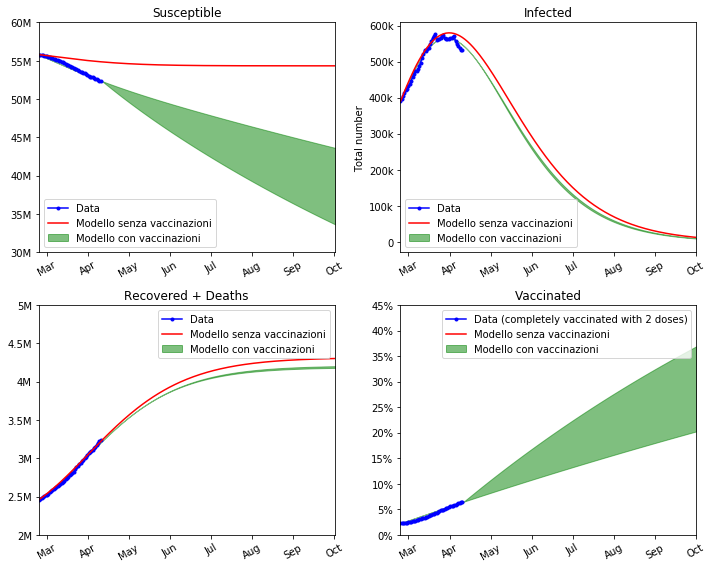

In [77]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(inhabitants-ydata_cases,label='Data',color='blue',marker='.')
plt.fill_between(xgrid,pred_lockdown_vaccine[1],pred_lockdown_vaccine_best[1],
                 label='Modello con vaccinazioni',alpha=0.5,color='green')
plt.plot(pred_lockdown_vaccine_zero[1],label='Modello senza vaccinazioni',color='red')
plt.xticks(np.arange(6,250,30.5),xlab,rotation=30)
plt.xlim(0,tmax)
plt.yticks(10**7*np.arange(0,6.1,0.5),['0','5M','10M','15M','20M','25M','30M','35M','40M','45M','50M','55M','60M'])
plt.ylim(30*10**6,60*10**6)
plt.title('Susceptible')
plt.legend()
plt.subplot(2,2,2)
plt.plot(ydata_inf_complete,label='Data',color='blue',marker='.')
plt.fill_between(xgrid,pred_lockdown_vaccine[2],pred_lockdown_vaccine_best[2],
                 label='Modello con vaccinazioni',alpha=0.5,color='green')
plt.plot(pred_lockdown_vaccine_zero[2],label='Modello senza vaccinazioni',color='red')
plt.title('Infected')
plt.yticks(10**5*np.arange(0,6.1,1),['0','100k','200k','300k','400k','500k','600k'])
plt.ylabel('Total number')
plt.xticks(np.arange(6,250,30.5),xlab,rotation=30)
plt.xlim(0,tmax)
plt.legend(loc=3)
plt.subplot(2,2,3)
plt.plot(ydata_rec,label='Data',color='blue',marker='.')
plt.fill_between(xgrid,pred_lockdown_vaccine[3],pred_lockdown_vaccine_best[3],
                 label='Modello con vaccinazioni',alpha=0.5,color='green')
plt.plot(pred_lockdown_vaccine_zero[3],label='Modello senza vaccinazioni',color='red')
plt.xticks(np.arange(6,250,30.5),xlab,rotation=30)
plt.xlim(0,tmax)
plt.title('Recovered + Deaths')
plt.yticks(10**6*np.arange(0,6.1,0.5),['0','0.5M','1M','1.5M','2M','2.5M','3M','3.5M','4M','4.5M','5M','5.5M','6M'])
plt.ylim(2*10**6,5*10**6)
plt.legend()
plt.subplot(2,2,4)
plt.title('Vaccinated')
plt.plot(vaccinated_2dose,label='Data (completely vaccinated with 2 doses)',color='blue',marker='.')
plt.fill_between(xgrid,pred_lockdown_vaccine_best[4]/inhabitants*100,
                 pred_lockdown_vaccine[4]/inhabitants*100,
                 label='Modello con vaccinazioni',alpha=0.5,color='green')
plt.plot(pred_lockdown_vaccine_zero[4],label='Modello senza vaccinazioni',color='red')
plt.xticks(np.arange(6,250,30.5),xlab,rotation=30)
plt.yticks(np.arange(0,46,5),['0%','5%','10%','15%','20%','25%','30%','35%','40%','45%'])
plt.ylim(0,45)
plt.xlim(0,tmax)
plt.legend()
plt.tight_layout()
plt.savefig('results/modello_italia_ondata3_vaccini_bande.png',dpi=300)
plt.show()